In [1]:
include("../src.jl")

simpson

# Формулы Ньютона-Котеса

Идея вывода формул Ньютона-Котеса заключаются в *кусочной полиномиальной интерполяции* подыинтегральной функции $f$.

## Формула прямоугольников

В формуле прямоугольников функция на отрезке $[x_{i-1}, x_i]$ считается постоянной:

```{margin}
Существуют также левый и правый варианты, но у них хуже точность.
```
```{math}
\int_{x_{i-1}}^{x_i} f(x)\diff x \approx f(x_{i-1/2}) h, \quad x_{i-1/2} = \frac{x_i - x_{i-1}}{2}.
```

Также эту формулу называют *midpoint rule*.

Составная формула прямоугольников имеет вид

```{math}
\int_a^b f(x)\diff x \approx \sum_{i=1}^n f(x_{i-1/2}) h.
```

:::{admonition} Функция : `midpoint`

**Формула прямоугольников.**

```julia
"""
Вычисляет по формуле прямоугольников интеграл ∫`f`dx на отрезке [`a`, `b`]
с равномерной сеткой из `n` интервалов.
Возвращает значение интеграла, узлы и значения функции в узлах.
"""
function midpoint(f, a, b, n)
    h = (b-a)/n
    x = [h/2 + i * h for i in 0:n-1]
    y = f.(x)
    int = h * sum(y)
    return int, x, y
end
```
:::

%%% demo

**Демонстрация.**

Ниже представлены графики численного интеграла

```{math}
\int_0^3 x e^{\sin 2x}
```

для разного числа точек.

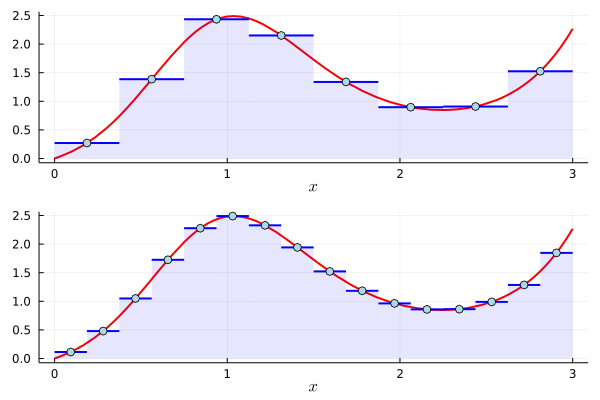

In [2]:
foo(x) = x * exp(sin(2x))
plt = plot(layout=(2,1), leg=:none, xlabel=L"x")
for (i, n) in enumerate((8, 16))
    _, x, y = midpoint(foo, 0, 3, n)
    plot!(foo, 0, 3; subplot=i, linewidth=2, linecolor=:red)

    for (px, py) in zip(x, y)
        h = 3 / n
        plot!([px-h/2, px+h/2], [py, py];
            subplot=i, fill=(0, 0.1, :blue), linecolor=:blue, linewidth=2
        )
    end
    scatter!(x, y; subplot=i, marker=:o, markercolor=:lightblue)
end
plt

% ref samarskiy
Можно показать, что формула прямоугольников имеет второй порядок сходимости

```{math}
|\tau_f(h)| \le \frac{h^2(b-a)}{24} \max_{x\in [a,b]} |f''(x)| \sim O(h^2).
```

При этом отсюда видно, что ошибка становится *нулевой* для линейных функций (для них $f'' \equiv 0$).

## Формула трапеций

На отрезке формула трапеций имеет вид

```{math}
\int_{x_{i-1}}^{x_i} f(x)\diff x \approx \frac{f(x_{i-1}) + f(x_i)}{2} h.
```

Она получается приближением $f(x)$ прямой на отрезке $[x_{i-1}, x_i]$.

Просуммировав {eq}`intsum`, получим квадратурную формулу на всём отрезке

```{math}
\int_a^b f(x)\diff x \approx T_f = h \left(\frac{1}{2} f(x_0) + f(x_1) + f(x_2) + ... + f(x_{n-1}) + \frac{1}{2}f(x_n)\right).
```

Из формулу трапеций выводятся многие усовершенствованные методы. Ниже дана реализация.

:::{admonition} Функция : `trapezoid`

**Формула трапеций.**

```julia
"""
Вычисляет по формуле трапеций интеграл ∫`f`dx на отрезке [`a`, `b`]
с равномерной сеткой из `n` интервалов.
Возвращает значение интеграла, узлы и значения функции в узлах.
"""
function trapezoid(f, a, b, n)
    h = (b-a)/n
    x = collect(range(a, b; length=n+1))
    y = f.(x)
    int = h * (sum(y[2:n]) + 0.5*(y[1] + y[n+1]))
    return int, x, y
end
```
:::

%%% demo

**Демонстрация.**

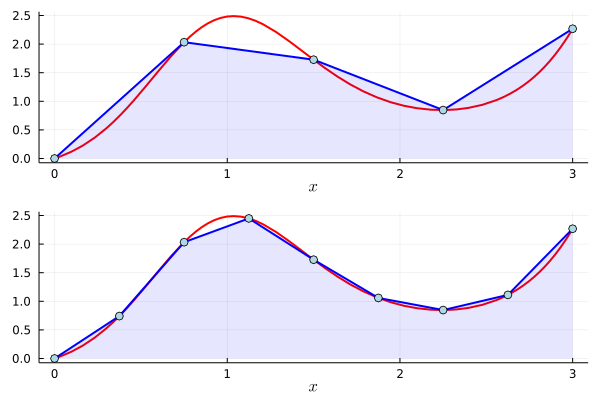

In [3]:
foo(x) = x * exp(sin(2x))
plt = plot(layout=(2,1), leg=:none, xlabel=L"x")
for (i, n) in enumerate((4, 8))
    _, x, y = trapezoid(foo, 0, 3, n)
    plot!(foo, 0, 3; subplot=i,linewidth=2, linecolor=:red)
    plot!(x, y; subplot=i, fill=(0, 0.1, :blue), linecolor=:blue, linewidth=2)
    scatter!(x, y; subplot=i, marker=:o, markercolor=:lightblue)
end
plt

% ref samarskiy
Для формулы трапеций можно показать, что

```{math}
|I - T_f| \le \frac{h^2(b-a)}{12} \max_{x\in[a,b]} f''(x) \sim O(h^2).
```

Таким образом, она обладает вторым порядком точности, как и формула прямоугольников. И также точно приближает интеграл от линейной функции.

## Формула Симпсона

Формулу Симпсона можно получить, интерполировав $f(x)$ на отрезке $[x_{i-1}, x_i]$ параболой по точкам $x_{i-1}, x_{i-1/2}, x_i$. Однако мы здесь покажем вывод на основе экстраполяции Ричардсона.

Для формулы трапеций на основе разложения Тейлора можно показать, что

```{math}
:label: simp_step1

I = T_f(h) + c_1 h^2 + O(h^4),
```

где $c_1$ не зависит от $h$.

Если мы проведём расчёт на сетке вдвое мельче, то получим

```{math}
:label: simp_step2

I = T_f(h/2) + c_1 \left(\frac{h}{2}\right)^2 + O(h^4).
```

Комбинируя выражения {eq}`simp_step1` и {eq}`simp_step2` так, чтобы уничтожить квадратичный член $c_1 h^2$, получим

```{math}
:label: simp_bigo
I = \frac{1}{3} \big[4 T_f(h/2) - T_f(h)\big] + O(h^4).
```

Обычно формулировка излагается относительно числа разбиений $n \propto h^{-1}$. Тогда  из выражения выше получаем формулу Симпсона

```{math}
S_f(2n) = \frac{1}{3} \big[4 T_f(2n) - T_f(n)\big].
```

%%% samraskiy ref

Из вывода {eq}`simp_bigo` видно, что формула Симпсона имеет чётвертый порядок сходимости. Более точная оценка

```{math}
|I - S_f(h)| \le \frac{h^4 (b-a)}{2880} \sup_{x\in [a,b]} f^{IV}(x) \sim O(h^4).
```

Отсюда видно, что формула Симпсона приближает точно многочлен степени не выше третьей.

Также приведём её явный вид

```{margin}
Можно избавиться от дробных индексов, если ввести сетку $x_i = a_i + 0.5 h i$, $i=0,..,2n$.
```
```{math}
\begin{align}
\int_a^b f(x) \diff x \approx S_f(h) &= \sum_{i=1}{n} \frac{h}{6}(f_{i-1} + 4 f_{i-1/2} + f_i) \\
&= \frac{h}{6}\big[f_0 + f_n + 2 (f_1 + f_2 + ... + f_{n-1}) + 4 (f_{1/2} + f_{3/2} + ... + f_{n-1/2}) \big].
\end{align}
```

%%% funcref

Ниже дана реализация на основе функции `trapezoid`.

:::{admonition} Функция : `simpson`

**Формула Симпсона.**

```julia
"""
Вычисляет по формуле Симпсона интеграл ∫`f`dx на отрезке [`a`, `b`]
с равномерной сеткой из `n` (чётное) интервалов.
Возвращает значение интеграла.
"""
function simpson(f, a, b, n)
    return (1/3) * (4*trapezoid(f, a, b, n)[1] - trapezoid(f, a, b, n÷2)[1])
end
```
:::

**Сравнение формул.**

Ниже представлены графики численного интеграла

```{math}
\int_0^3 x e^{\sin 2x}
```

в зависимости от числа интервалов $n$ для разных формул.

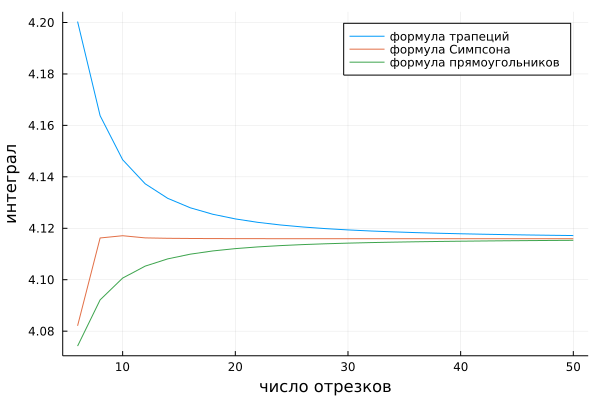

In [4]:
foo(x) = x * exp(sin(2x))
a, b = 0, 3
simp(n) = simpson(foo, a, b, n)
trap(n) = trapezoid(foo, a, b, n)[1]
midp(n) = midpoint(foo, a, b, n)[1]
n = 6:2:50
plot(n, trap.(n); label="формула трапеций", xlabel="число отрезков", ylabel="интеграл")
plot!(n, simp.(n); label="формула Симпсона")
plot!(n, midp.(n); label="формула прямоугольников")